## Lab Work 5: Fair Evaluation and Monte Carlo

This notebook builds on the third lecture of Foundations of Machine Learning. We'll focus on Fair Evaluation and Monte Carlo.

Important note: the steps shown here are not always the most efficient or the most "industry-approved." Their main purpose is pedagogical. So don't panic if something looks suboptimal—it's meant to be.

If you have questions (theoretical or practical), don't hesitate to bug your lecturer.


First the necessary imports:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score
from sklearn.inspection import permutation_importance

### 1. Load the dataset

For this lecture we will use the Pulsar dataset you used in the previous Lecture. 

Taks: load it, print the head and split features from target.

In [2]:
df = pd.read_csv("NB4 - Pulsars.csv")
print(df.head())
X = df.drop(columns=["target"])
y = df["target"]

         Mean        Std  Excess_kurtosis  Skewness  target
0  140.562500  55.683782        -0.234571 -0.699648       0
1  102.507812  58.882430         0.465318 -0.515088       0
2  103.015625  39.341649         0.323328  1.051164       0
3  136.750000  57.178449        -0.068415 -0.636238       0
4   88.726562  40.672225         0.600866  1.123492       0


### 2. Stratified K-Fold Cross-Validation

Goal: Split the dataset into k folds for cross-validation while preserving the proportion of classes in each fold (important for imbalanced datasets).

Procedure: use sklearn to create the stratification, the pipeline and to iterate through the splits. Then print the summary statistic (balanced accuracy).

### Accuracy vs Balanced Accuracy

**Accuracy:**  
- Measures the proportion of correctly classified samples:  
$
\text{Accuracy} = \frac{\text{Number of correct predictions}}{\text{Total number of predictions}}
$ 
- Works well when classes are balanced.  
- Can be **misleading for imbalanced datasets**, because predicting the majority class gives high accuracy even if the model ignores the minority class.  

**Balanced Accuracy:**  
- Averages the recall for each class, giving equal weight to all classes:  
$
\text{Balanced Accuracy} = \frac{1}{2} \left( \frac{\text{TP}}{\text{TP + FN}} + \frac{\text{TN}}{\text{TN + FP}} \right)
$
- Ensures the model performs well on **both majority and minority classes**.  
- Particularly useful for **imbalanced classification problems**.

In [3]:
# Define stratified k-fold with 5 splits
skf = StratifiedKFold(n_splits=20, shuffle=True, random_state=42)

# Store accuracy for each fold
accs = []

# Build a pipeline:
# Step 1: StandardScaler to normalize features
# Step 2: LogisticRegression to fit the model
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("logistic", LogisticRegression(penalty="l2",          # L2 regularization
        solver="lbfgs",        # default solver, supports L2
        C=1.0,
        max_iter=500))  # max_iter increased to ensure convergence
])

# Iterate through each fold
for train_idx, test_idx in skf.split(X, y):
    # Extract training and test sets for this fold
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Fit the pipeline on training data
    pipe.fit(X_train, y_train)

    # Predict on the test fold
    y_pred = pipe.predict(X_test)

    # Compute accuracy for this fold
    acc = balanced_accuracy_score(y_test, y_pred)
    accs.append(acc)
    print(f"Fold accuracy: {acc:.4f}")

# Summary statistics across folds
print(f"Mean accuracy: {np.mean(accs):.4f}, Std: {np.std(accs):.4f}\n")

Fold accuracy: 0.9433
Fold accuracy: 0.9103
Fold accuracy: 0.8884
Fold accuracy: 0.8701
Fold accuracy: 0.9433
Fold accuracy: 0.8603
Fold accuracy: 0.8939
Fold accuracy: 0.8884
Fold accuracy: 0.9189
Fold accuracy: 0.8872
Fold accuracy: 0.9109
Fold accuracy: 0.9103
Fold accuracy: 0.9067
Fold accuracy: 0.8634
Fold accuracy: 0.8524
Fold accuracy: 0.8756
Fold accuracy: 0.8817
Fold accuracy: 0.9134
Fold accuracy: 0.8994
Fold accuracy: 0.8878
Mean accuracy: 0.8953, Std: 0.0243



### 3. Bootstrap

**Goal:** Estimate the variability of model performance and compute confidence intervals.  

**Procedure:**  
- Resample the training data **with replacement** to create bootstrap datasets.  
- Use the **out-of-bag samples** as test sets.  
- Fit the pipeline on each bootstrap sample and record accuracy.  
- Repeat for `B` iterations and compute a **95% confidence interval** from the distribution of accuracies.  
- Visualize with a histogram and mark the mean accuracy.

95% CI for accuracy: [0.8815, 0.9103]


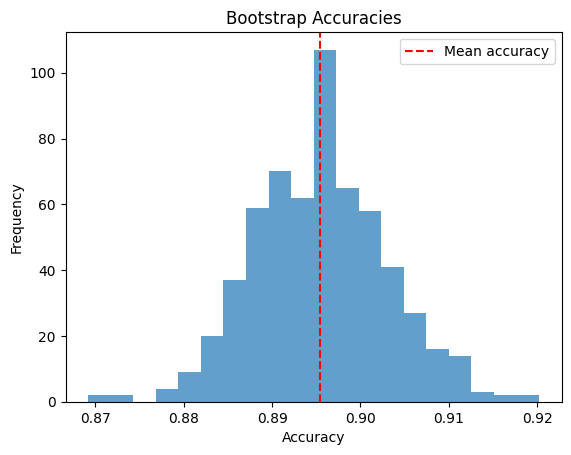

In [4]:
def bootstrap_accuracy(model, X, y, B=600, random_state=42):
    np.random.seed(random_state)
    n = len(y)
    boot_accs = []

    for _ in range(B):
        # Sample with replacement from the dataset
        idx = np.random.choice(n, n, replace=True) #[0,50,40,40,40,30] -> training
        X_train_boot = X.iloc[idx]
        y_train_boot = y.iloc[idx]

        # Out-of-bag (OOB) indices as test set
        oob_idx = np.setdiff1d(np.arange(n), np.unique(idx)) #[0,...,99,100] - [0,30,40,50]=[...]

       
        if len(oob_idx) == 0:
            continue  # skip if no OOB samples (rare)

        X_test_oob = X.iloc[oob_idx]
        y_test_oob = y.iloc[oob_idx]

        # Fit model and evaluate on OOB
        model.fit(X_train_boot, y_train_boot)
        y_pred = model.predict(X_test_oob)
        boot_accs.append(balanced_accuracy_score(y_test_oob, y_pred))

    return np.array(boot_accs)

# Compute bootstrap accuracies
boot_accs = bootstrap_accuracy(pipe, X, y)

# Compute 95% confidence interval
ci_lower, ci_upper = np.percentile(boot_accs, [2.5, 97.5])
print(f"95% CI for accuracy: [{ci_lower:.4f}, {ci_upper:.4f}]")

# Plot histogram of bootstrap accuracies
plt.hist(boot_accs, bins=20, alpha=0.7)
plt.axvline(np.mean(boot_accs), color='red', linestyle='--', label="Mean accuracy")
plt.xlabel("Accuracy")
plt.ylabel("Frequency")
plt.title("Bootstrap Accuracies")
plt.legend()
plt.show()

### 4. Permutation Training Importance — Single Feature

**Goal:** Assess the importance of a single feature for model performance. Caution: I am **retraining** with a broken feature, meaning I ask "how much that feature is important to learn something?".

**Procedure:**  
- Compute baseline accuracy of the model with all features.  
- Randomly **shuffle the values** of the feature of interest.  
- Evaluate the model on the permuted data.  
- Repeat for multiple permutations to get a distribution of accuracies.  
- Compare baseline accuracy to the permuted distribution: a large drop indicates a **relevant feature**.

Baseline accuracy: 0.8953


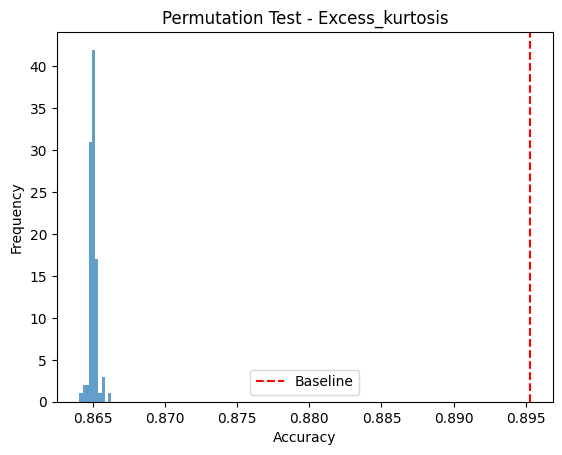

In [9]:
feature = "Excess_kurtosis"  # choose a feature from your dataset

# Fit model on original data
baseline_model = pipe
baseline_model.fit(X, y)
baseline_acc = balanced_accuracy_score(y, baseline_model.predict(X))
print(f"Baseline accuracy: {baseline_acc:.4f}")

n_permutations = 100
perm_accs = []

# Shuffle the feature column to break its relationship with target
for _ in range(n_permutations):
    X_perm = X.copy()
    X_perm[feature] = np.random.permutation(X_perm[feature]) #I broke the feature relationship here
    baseline_model.fit(X_perm, y)
    perm_accs.append(balanced_accuracy_score(y, baseline_model.predict(X_perm)))

# Plot histogram of permuted accuracies
plt.hist(perm_accs, bins=10, alpha=0.7)
plt.axvline(baseline_acc, color='red', linestyle='--', label="Baseline")
plt.xlabel("Accuracy")
plt.ylabel("Frequency")
plt.title(f"Permutation Test - {feature}")
plt.legend()
plt.show()

### 5. Permutation Predicting Importance 

**Goal:** Quantify the relevance of each feature for model performance. Caution: I am **not retraining**, meaning I ask "how much that feature is important to predict in a meaningful way?".

**Procedure:**  
- Fit the pipeline on the full dataset.  
- Use `sklearn.inspection.permutation_importance` to shuffle each feature multiple times.  
- Measure the decrease in model accuracy for each feature.  
- Features causing a large drop are **more important**.  
- Visualize the results with a bar chart of mean decreases in accuracy.

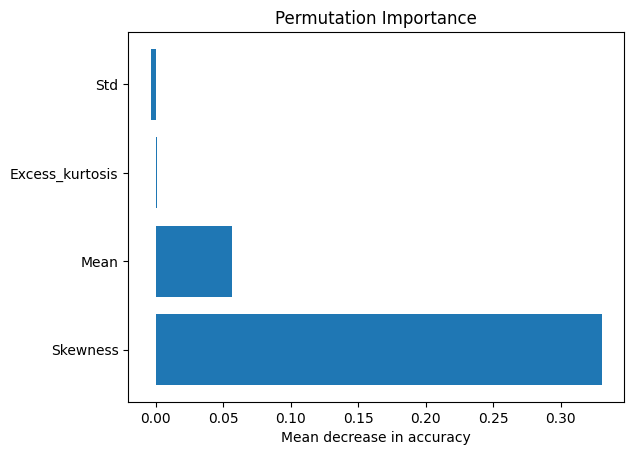

In [10]:
# Evaluate decrease in accuracy when each feature is shuffled
perm_importance = permutation_importance(
    pipe, X, y, n_repeats=30, random_state=42, scoring='balanced_accuracy'
)
importances = perm_importance.importances_mean

# Sort features by importance
features_sorted = X.columns[np.argsort(importances)][::-1]

# Plot horizontal bar chart
plt.barh(features_sorted, np.sort(importances)[::-1])
plt.xlabel("Mean decrease in accuracy")
plt.title("Permutation Importance")
plt.show()



### 6. Permutation Training Importance groups



Task: create two groups of features, permute and **refit**. Compare the drop in accuracy: why is it different from the single feature permutation?

Baseline accuracy: 0.8953


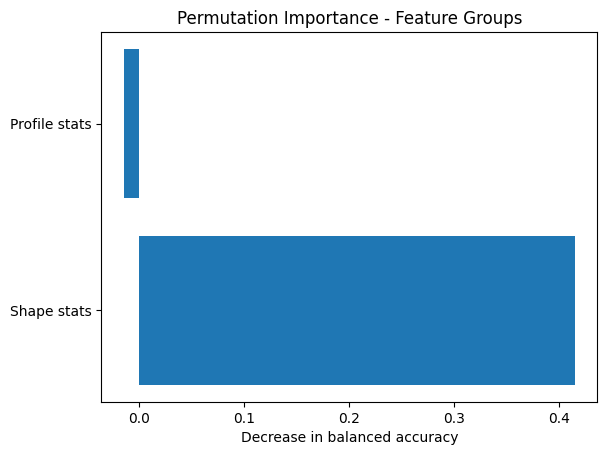

In [15]:

from sklearn.base import clone

# Define your feature groups
feature_groups = {
    "Profile stats": ["Mean", "Std","Skewness"],
    "Shape stats": [ "Excess_kurtosis"]
}

# Store results
group_importances = {}
pipe.fit(X, y)
baseline_acc = balanced_accuracy_score(y, pipe.predict(X))

print(f"Baseline accuracy: {baseline_acc:.4f}")

for group_name, cols in feature_groups.items():
    accs = []
    n_repeats = 30
    for _ in range(n_repeats):
        X_perm = X.copy()
        X_perm[cols] = X_perm[cols].apply(np.random.permutation)
        # pipe_clone = clone(pipe)  # decomment if you want to refit, meaning if you want to assess if the model needs that feature to learn
        # pipe_clone.fit(X_perm, y) # two different concepts!!
        accs.append(balanced_accuracy_score(y, pipe.predict(X_perm)))
    group_importances[group_name] = baseline_acc - np.mean(accs)

# Sort by importance
group_sorted = dict(sorted(group_importances.items(), key=lambda item: item[1], reverse=True))

# Plot
plt.barh(list(group_sorted.keys()), list(group_sorted.values()))
plt.xlabel("Decrease in balanced accuracy")
plt.title("Permutation Importance - Feature Groups")
plt.show()

### 7. Monte Carlo Permutation Test (We will discuss it next time quickly)

**Goal:** Test whether the model's performance is significantly better than chance.  Here permutation acts on **labels**!!

**Procedure:**  
- Randomly **permute the target labels** multiple times (B iterations).  
- Fit the model on each permuted dataset and record the accuracy.  
- Compare the true model accuracy to the distribution of accuracies under the null hypothesis.  
- Compute the **p-value**: proportion of permuted accuracies ≥ true accuracy.  
- Visualize with a histogram marking the true accuracy.

Estimated p-value: 0.0000
[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5

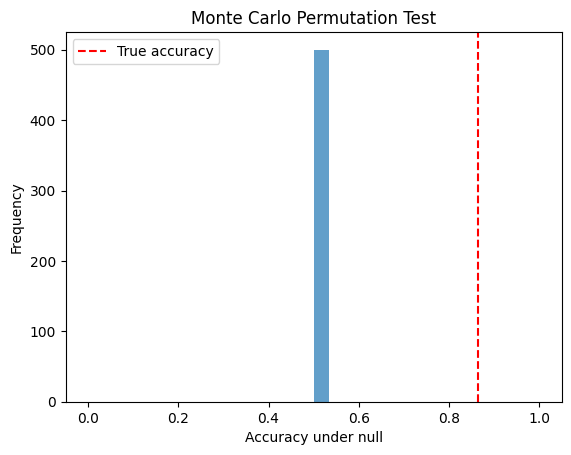

In [8]:
B = 500  # number of permutations
null_accs = []

#what if I do not use balanced accuracy score?

true_acc = balanced_accuracy_score(y, pipe.predict(X))
null_accs = []

for _ in range(B):
    y_perm = np.random.permutation(y)
    pipe.fit(X, y_perm)
    null_accs.append(balanced_accuracy_score(y_perm, pipe.predict(X)))

p_value = np.mean(np.array(null_accs) >= true_acc)
print(f"Estimated p-value: {p_value:.4f}")

# Plot histogram of null accuracies
plt.hist(null_accs, bins=30, alpha=0.7)
print(null_accs)
print(true_acc)
plt.axvline(baseline_acc, color='red', linestyle='--', label="True accuracy")
plt.xlabel("Accuracy under null")
plt.ylabel("Frequency")
plt.title("Monte Carlo Permutation Test")
plt.legend()
plt.show()